# ICDSS Advanced Data Science Team Challenges 2017-2018

### Author : David JIA

### CID : 01418670

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import xgboost as xgb
from PIL import Image
import time
from IPython.display import HTML, display
import tabulate
%matplotlib inline

## I - Data analyzing

### 1) Understanding, normalizing, creating small dataset

We first try to understand the datas : 60000 images in the training set and 10000 in the testing set. We need to classify them into 10 different classes.

In [2]:
from reader import get_images
(x_train, y_train), (x_test, y_test) = get_images() 
print'X_train shape : ', x_train.shape
print'y_train shape : ', y_train.shape
print'X_test shape : ', x_test.shape
print'y_test shape : ', y_test.shape

We normalize the datas and we also create a small dataset to work with. We also check that the number of each class in the training set is equivalent, so we have a balanced small training set (6000 datas instead of 60000).

X_train shape :  (60000, 784)
y_train shape :  (60000,)
X_test shape :  (10000, 784)
y_test shape :  (10000,)
[9 0 0 ..., 6 7 0]


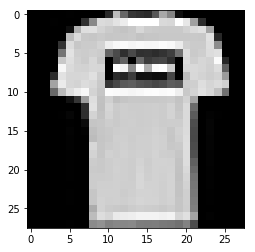

In [3]:
x_train = x_train/255.0
x_test = x_test/255.0
x_train_small = x_train[:6000]
y_train_small = y_train[:6000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]

N_train, d_train = x_train.shape
N_test, d_test = x_test.shape
plt.imshow(x_train[1].reshape((28,28)), cmap='gray')

### 2) Dimension reduction

The main issue with Image Processing is the high dimention of the datas (dimension=784). So we need to reduce it while conserving as much information as we can. Thus, we use 2 methods : PCA and LDA. 
-  PCA converts a set of observations into a set of linearly uncorrelated variables called principal components. 
- In LDA, the weights are updated by seeking directions that are efficient for discrimination

In [96]:
i = 1
pca = decomposition.PCA(n_components=2)
X_proj = pca.fit_transform(x_train[i].reshape(1,-1))
X_recons = pca.inverse_transform(X_proj)
#plt.imshow(X_recons.reshape((28,28)), cmap='gray')
mse = mean_squared_error(x_train[i], np.transpose(X_recons))
print(mse)

0.0


In [126]:
#PCA dimension reduction
start = time.time()
pca = decomposition.PCA(n_components=100)
pca.fit(x_train)
X_reduced_train = pca.transform(x_train)
X_reduced_test = pca.transform(x_test)

print'Time in %fs' % (time.time()-start)

Time in 9.683751s


In [127]:
#PCA dimension reduction SMALL Dataset
start = time.time()
pca = decomposition.PCA(n_components=100)
pca.fit(x_train)
x_train_pca = pca.transform(x_train_small)
x_test_pca = pca.transform(x_test_small)

print'Time in %fs' % (time.time()-start)

Time in 10.470955s


In [122]:
#LDA dimension reduction
start = time.time()
lda = LinearDiscriminantAnalysis(n_components=100)
lda.fit(x_train, y_train)
X_train_lda = lda.transform(x_train)
X_test_lda = lda.transform(x_test)

print'Time in %fs' % (time.time()-start)

Time in 21.480780s


In [123]:
#LDA dimension reduction SMALL Dataset
start = time.time()
lda = LinearDiscriminantAnalysis(n_components=100)
lda.fit(x_train_small, y_train_small)
x_train_lda = lda.transform(x_train_small)
x_test_lda = lda.transform(x_test_small)

print'Time in %fs' % (time.time()-start)

Time in 2.521812s


### 3) Data augmentation

In order to create more datas to have a larger training set (very useful for deep learning), we did data augmentation by rotating and making symetric images while keeping the same label. 

#### (i) Rotation 

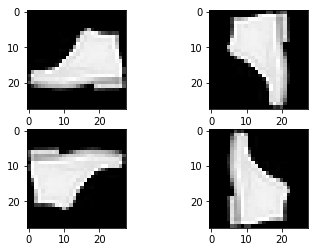

In [4]:
img1 = x_train[42].reshape((28,28))
img2 = np.rot90(img1)
img3 = np.rot90(img2)
img4 = np.rot90(img3)

plt.figure(1)
plt.subplot(221)
plt.imshow(img1, cmap='gray')
plt.subplot(222)
plt.imshow(img2, cmap='gray')
plt.subplot(223)
plt.imshow(img3, cmap='gray')
plt.subplot(224)
plt.imshow(img4, cmap='gray')

#### (ii) Symmetric images

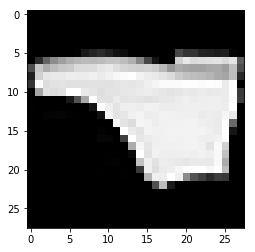

In [5]:
img1 = x_train[42].reshape((28,28))
imgS1 = np.transpose(img1)
imgS2 = np.rot90(imgS1)
plt.imshow(imgS2, cmap='gray')

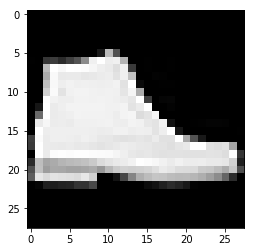

In [6]:
x_trainR1 = np.zeros((N_train,28,28))
x_trainR2 = np.zeros((N_train,28,28))
x_trainR3 = np.zeros((N_train,28,28))
x_trainR4 = np.zeros((N_train,28,28))

x_trainS1 = np.zeros((N_train,28,28))
x_trainS2 = np.zeros((N_train,28,28))
x_trainS3 = np.zeros((N_train,28,28))
x_trainS4 = np.zeros((N_train,28,28))

for i in range(N_train):
    img1 = x_train[i].reshape((28,28))
    img2 = np.rot90(img1)
    img3 = np.rot90(img2)
    img4 = np.rot90(img3)
    x_trainR1[i] = img1
    x_trainR2[i] = img2
    x_trainR3[i] = img3
    x_trainR4[i] = img4
    x_trainS1[i] = np.transpose(img1)
    x_trainS2[i] = np.transpose(img2)
    x_trainS3[i] = np.transpose(img3)
    x_trainS4[i] = np.transpose(img4)
    
plt.imshow(x_trainS2[42],cmap='gray')

In [7]:
y_trainR1 = y_train
y_trainR2 = y_train
y_trainR3 = y_train
y_trainR4 = y_train

y_trainS1 = y_train
y_trainS2 = y_train
y_trainS3 = y_train
y_trainS4 = y_train

#### (iii) Noisy images

We could have created more images by adding white noise with a low variance, so we can still recognize the image.

In [114]:
# We concatenate the augmented dataset.
X_train_da = np.concatenate((x_trainR1,x_trainR2,x_trainR3,x_trainR4,x_trainS1,x_trainS2,x_trainS3,x_trainS4), axis=0)
Y_train_da = np.concatenate((y_trainR1,y_trainR2,y_trainR3,y_trainR4,y_trainS1,y_trainS2,y_trainS3,y_trainS4), axis=0)

## II - Sklearn classifiers

In [116]:
def classifier(clf, x_train, y_train, x_test, y_test):
    start = time.time()
    clf.fit(x_train, y_train)
    y_pred_train = clf.predict(x_train)
    y_pred_test = clf.predict(x_test)
    print'Training score : ', accuracy_score(y_train, y_pred_train)
    print'Testing score : ', accuracy_score(y_test, y_pred_test)
    print'Time in %fs'% (time.time()-start)
    
    return y_pred_train, y_pred_test

### 1) LDA Classifier

In [129]:
#Without dimension reduction
y_pred_train, y_pred_test = classifier(LinearDiscriminantAnalysis(), x_train, y_train, x_test, y_test)

Training score :  0.832583333333
Testing score :  0.8151
Time in 15.698370s


In [128]:
#With PCA reduction
y_pred_train, y_pred_test = classifier(LinearDiscriminantAnalysis(), X_reduced_train, y_train, X_reduced_test, y_test)

Training score :  0.8087
Testing score :  0.7993
Time in 1.598523s


In [125]:
#With LDA reduction
y_pred_train2, y_pred_test2 = classifier(LinearDiscriminantAnalysis(), X_train_lda, y_train, X_test_lda, y_test)

Training score :  0.832583333333
Testing score :  0.8151
Time in 0.126806s


### 2) SVM Classifier

In [134]:
#Without dimension reduction
y_pred_train, y_pred_test = classifier(LinearSVC(), x_train_small, y_train_small, x_test_small, y_test_small)

Training score :  0.959833333333
Testing score :  0.812
Time in 10.224273s


In [135]:
#With PCA reduction
y_pred_train, y_pred_test = classifier(LinearSVC(), x_train_pca, y_train_small, x_test_pca, y_test_small)

Training score :  0.8665
Testing score :  0.833
Time in 4.444924s


In [136]:
#With LDA reduction
y_pred_train2, y_pred_test2 = classifier(LinearSVC(), x_train_lda, y_train_small, x_test_lda, y_test_small)

Training score :  0.8895
Testing score :  0.811
Time in 0.794078s


### 3) Bayesian Classifier

In [141]:
gnb = GaussianNB()
#With PCA reduction
y_pred_train, y_pred_test = classifier(gnb, x_train_pca, y_train_small, x_test_pca, y_test_small)

Training score :  0.783333333333
Testing score :  0.77
Time in 0.061117s


In [142]:
#With LDA reduction
y_pred_train, y_pred_test = classifier(gnb, x_train_lda, y_train_small, x_test_lda, y_test_small)
#y_pred_train2, y_pred_test2 = classifier(mnb, X_train_lda, y_train, X_test_lda, y_test)

Training score :  0.881166666667
Testing score :  0.8
Time in 0.014783s


In [143]:
#Without dimension reduction
y_pred_train, y_pred_test = classifier(gnb, x_train_small, y_train_small, x_test_small, y_test_small)

Training score :  0.5445
Testing score :  0.551
Time in 1.004667s


### 4) XGBoost

XGBoost is a very popular algorithm using Boosting Trees. Even though it's not optimal with high dimension datas (it can take a long time), the results should be good.

In [138]:
#With PCA dimension reduction
start = time.time()
gbm = xgb.XGBClassifier(max_depth=50, n_estimators=100, learning_rate=0.05).fit(x_train_pca, y_train_small)
y_pred_train = gbm.predict(x_train_pca)
y_pred_test = gbm.predict(x_test_pca)
print'Training score : ', accuracy_score(y_train_small, y_pred_train)
print'Testing score : ', accuracy_score(y_test_small, y_pred_test)
print'Time in %fs'% (time.time()-start)

Training score :  1.0
Testing score :  0.827
Time in 67.982848s


In [139]:
#With LDA dimension reduction
start = time.time()
gbm = xgb.XGBClassifier(max_depth=50, n_estimators=100, learning_rate=0.05).fit(x_train_lda, y_train_small)
y_pred_train = gbm.predict(x_train_lda)
y_pred_test = gbm.predict(x_test_lda)
print'Training score : ', accuracy_score(y_train_small, y_pred_train)
print'Testing score : ', accuracy_score(y_test_small, y_pred_test)
print'Time in %fs'% (time.time()-start)

Training score :  0.9995
Testing score :  0.798
Time in 5.634974s


In [140]:
# Without dimension reduction
start = time.time()
gbm = xgb.XGBClassifier(max_depth=50, n_estimators=100, learning_rate=0.05).fit(x_train_small, y_train_small)
y_pred_train = gbm.predict(x_train_small)
y_pred_test = gbm.predict(x_test_small)
print'Training score : ', accuracy_score(y_train_small, y_pred_train)
print'Testing score : ', accuracy_score(y_test_small, y_pred_test)
print'Time in %fs'% (time.time()-start)

Training score :  1.0
Testing score :  0.85
Time in 188.089623s


In [153]:
# Display table for SMALL DATASET
table = [["","PCA Reduction","LDA Reduction","Without Reduction"],
        ["Train score",1.0, 1.0, 1.0],
         ["Test score",0.821, 0.798, 0.85],
         ["Time (in s)",77,6.2, 182]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

,PCA Reduction,LDA Reduction,Without Reduction
Train score,1.0,1.0,1.0
Test score,0.821,0.798,0.85
Time (in s),77,6.2,182


The results were quite good, but the model is not well adapted to the problem because trees are very good for structured datas. which isn't the case of Image Classification.

The next step would be to do ensemble learning and to combine all those different classifiers with a system of votes, to improve the result. However, as there are many datas (60000 trainings), we believe that the best way to have good results is to use deep learning.

## III - Neural Networks

Neural Networks have always shown good performances in Machine Learning problems. However, Image Processing is a high dimension problems, and the time to update weighs can be very long. CNN is anther kind of neural network which has showed excellent results for Image processing and NLP. By adding a pooling layer, we can decrease the dimension of the datas. So we are going to implement one.

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
K.set_image_dim_ordering('th')

In [10]:
# one hot encode outputs
# Total datas
y_train_hot = np_utils.to_categorical(y_train)
y_test_hot = np_utils.to_categorical(y_test)

# Small datas
y_train_dummies = np_utils.to_categorical(y_train_small)
y_test_dummies = np_utils.to_categorical(y_test_small)

# Augmented datas
y_train_da = np_utils.to_categorical(Y_train_da)

num_classes = y_test_hot.shape[1]
print(y_train_hot.shape)

(60000, 10)


In [11]:
X_train_temp = x_train
X_test_temp = x_test
X_train_temp2 = x_train_small
X_test_temp2 = x_test_small
X_train = X_train_temp.ravel().reshape(60000,1,28,28)
X_test = X_test_temp.ravel().reshape(10000,1,28,28)
X_train_small = X_train_temp2.ravel().reshape(6000,1,28,28)
X_test_small = X_test_temp2.ravel().reshape(1000,1,28,28)

x_train_da = X_train_da.ravel().reshape(480000,1,28,28)

print(X_train.shape)
print(X_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [19]:
# Create the model
model = Sequential()
model.add(Conv2D(28, (3, 3), input_shape=(1,28, 28), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(28, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 15
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 28)        7084      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 14, 14)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5488)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2810368   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`
  


In [21]:
start = time.time()
# Fit the model
model.fit(X_train_small, y_train_dummies, validation_data=(X_test_small, y_test_dummies), epochs=epochs, batch_size=25)
print'Time in %fs' % (time.time()-start)

Train on 6000 samples, validate on 1000 samples
Epoch 1/15
6000/6000 [==============================] - 80s 13ms/step - loss: 0.3466 - acc: 0.8723 - val_loss: 0.3274 - val_acc: 0.8860
Epoch 2/15
6000/6000 [==============================] - 81s 14ms/step - loss: 0.3264 - acc: 0.8800 - val_loss: 0.3379 - val_acc: 0.8760
Epoch 3/15
6000/6000 [==============================] - 66s 11ms/step - loss: 0.3003 - acc: 0.8902 - val_loss: 0.3218 - val_acc: 0.8790
Epoch 4/15
6000/6000 [==============================] - 62s 10ms/step - loss: 0.2912 - acc: 0.8943 - val_loss: 0.3175 - val_acc: 0.8920
Epoch 5/15
6000/6000 [==============================] - 64s 11ms/step - loss: 0.2678 - acc: 0.9033 - val_loss: 0.3324 - val_acc: 0.8840
Epoch 6/15
6000/6000 [==============================] - 65s 11ms/step - loss: 0.2590 - acc: 0.9058 - val_loss: 0.3173 - val_acc: 0.8970
Epoch 7/15
6000/6000 [==============================] - 74s 12ms/step - loss: 0.2382 - acc: 0.9133 - val_loss: 0.3162 - val_acc: 0.8880


In [24]:
start = time.time()

# Evaluation of the model
scores1 = model.evaluate(X_train_small, y_train_dummies, verbose=0)
scores2 = model.evaluate(X_test_small, y_test_dummies, verbose=0)
print("Train accuracy: %.2f%%" % (scores1[1]*100))
print("Test accuracy: %.2f%%" % (scores2[1]*100))

print'Time in %fs' % (time.time()-start)

Train accuracy: 96.30%
Test accuracy: 88.90%
Time in 35.179054s


In [155]:
# Display table for SMALL DATASET
table = [["Number of Epochs", 5, 25, 100],
        ["Train score",0.87, 0.98, 1.0],
         ["Test score",0.83, 0.88, 0.88],
         ["Time (in min)",6, 22, 115]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Number of Epochs,5,25,100
Train score,0.87,0.98,1
Test score,0.83,0.88,0.88
Time (in min),6,22,115


In [156]:
# Display table for FULL DATASET
table = [["Number of Epochs", 5, 25],
        ["Train score",0.95, 0.97],
         ["Test score",0.89, 0.92],
         ["Time (in min)",6, 22]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Number of Epochs,5,25
Train score,0.95,0.97
Test score,0.89,0.92
Time (in min),6,22


We also calculated the scores for different parameters : 
- loss function : same results with Adam loss and sgd loss.
- number of conv layers : we loose 2% in testing score when we have 1 conv layer instead of 2.
- size of selected regions : same results for (2,2), (3,3) or (4,4)

Moreover, we also used this CNN with the Augmented Datas from I-2), but the results are the same. Need to find a more robust model.

### Conclusion and possible improvements

The best result was obtained with a CNN (between 89 and 92% with 25 epochs). After reading several articles, I think the best way to improve the result would be to implement state of the art neural networks with Keras. I would have tried : 
- different type of resnet.
- more recent CNN such as RCNN.
<br> <br>
Then, after predicting the labels, I would have combining all the different neural networks with a voting system to obtain a new score.